### Read in audio file and ensure that the path is correct.

In [3]:
import os

# Find out which language to use
lang_code = input(
    "What Language Do You Want to Use? (e.g. en-US, de-DE, fr-FR, hi-IN, zh-CN, etc;)")
if(lang_code != "en-US"):
    print("Sorry, only english is supported!")
    quit()

found_file = False
file_path = input(
    "Enter the path to an audio file. \n Please note that it must be a .wav file:")
while(found_file == False):
    found_file = os.path.exists(file_path) and file_path[-3:] == "wav"
    if(found_file == False):
        file_path = input("That file-path was invalid, Please try again:")
print("File was succesfully input!")


File was succesfully input!


### Figure out the sampling rate of the .wav file.

In [4]:
from scipy.io.wavfile import read as read_wav

sampling_rate, data = read_wav(file_path)
print("The sampling rate of the file is: {} Hz.".format(sampling_rate))

The sampling rate of the file is: 8000 Hz.


### Upload the file to Google Cloud Storage for transcription.

In [ ]:
from google.cloud import storage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\rockr\Desktop\Code\SRP\sample-key.json"

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    # Uploads a file to the bucket.

    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    # print(
    #     "File {} uploaded to {}.".format(
    #         source_file_name, destination_blob_name
    #     )
    # )
    print("File was successfully uploaded to Google Cloud Storage!")


upload_blob("srp_speech_to_text", file_path, "audio_file_for_transcription.wav")

### Transcribe the file and create a list of all the sentences.

In [6]:
from google.cloud import speech

# Instantiates a client
client = speech.SpeechClient()

# The name of the audio file to transcribe
gcs_uri = "gs://srp_speech_to_text/audio_file_for_transcription.wav"

audio = speech.RecognitionAudio(uri=gcs_uri)

config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=sampling_rate,
    language_code="en-US",
)

# Detects speech in the audio file
response = client.recognize(config=config, audio=audio)

sentences = []
for result in response.results:
    s = (format(result.alternatives[0].transcript))
    if(s[0] == ' '):
        s = s[:0] + s[1:]
    # print(s)
    sentences.append(s)


C:\Users\rockr\anaconda3\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


### Turn each of the sentences into an image.

### Install package

In [8]:
# %cd "C:\Users\rockr\Desktop\Code\SRP\SRP Code"
# !git clone https://github.com/openai/glide-text2im.git
# %pip install -q -e .
%cd "C:\Users\rockr\Desktop\Code\SRP\SRP Code\glide-text2im"

C:\Users\rockr\Desktop\Code\SRP\SRP Code\glide-text2im


### Set-up functions, models and options

In [9]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [10]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [19]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '50' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [20]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [21]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

### Sample at 64x64 resolution

100%|██████████| 50/50 [07:10<00:00,  8.62s/it]


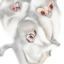

In [22]:
prompt = "a high quality painting of monkeys"

# Sampling parameters
batch_size =  1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 1 #@param {type:"number"}

##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

show_images(samples)

### Upsample to 256x256 resolution

100%|██████████| 27/27 [08:18<00:00, 18.47s/it]


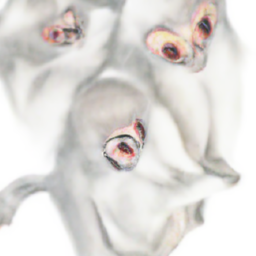

In [23]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()


show_images(up_samples)